# Transfer Learning
This project should introduce you to transfer learning techniques. The checklist below shows the steps necessary to finish the project.
- **Prepare a dataset**. The dataset shall be desined for image classification, and be organized to work with keras.applications (training, validation and test data should be in different folders. Images from one class should be in one subfolder). 
- **Select the network**. Select the network you want to work with. In the original code `Xception` network is selected, but you may change it if you want.
- **Complete functions**. Complete missing code in the following functions
    - `add_new_last_layer` - adds an output layer to your model. You may also add some layers in between. If so, remember to unfreeze these layers in `setup_to_transfer_learn` function
    - `setup_to_transfer_learn` - Freezes all layers but the last one and compiles the model
    - `setup_to_finetune` - Freezes the first not_trainable layers, and unfreezes the rest
    - `train_generator` - Creates a generator feed with train dataset. You should add data augmentation to it
- **Perorm training**. Perform model trainig slowly unfreezeng the layers as long as you do not observe overfitting. In case of overfitting get back to previous model.
- **Test your model on real images**. Write a code that tests your model on real images. You should display an image, a real class of an image, the class selected by the model, and the probabilities assined by the model to all the classes.

In [2]:
import os
import sys
import glob

import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Nadam


%matplotlib inline

In [3]:
# Run if you are using google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Run to see how to access your google drive
!ls "/content/drive/My Drive/datasets/Alzheimer Dataset"

test  train  valid


In [5]:
# If you have more than 1 GPU and you want to train on the first one only
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        print ('No directory')
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
              cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
    Arguments:
        base_model: keras model (without a top layer)
        nb_classes: number of classes
    Returns:
        new keras model with last layer
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add the last layer and ((optionally) a dense layer
    # ENTER YOUR CODE HERE 
    predictions = Dense(4, activation = "softmax")(x)
    #END OF YOUR CODE
    model = Model(inputs=base_model.input, outputs=predictions)
    return model



def setup_to_transfer_learn(model, args):
    """Freezes all layers but the last one and compiles the model"""
    
    # TODO: Set all the layers but last one to not trainable.
    # Note: If you added more than one layer in the add_new_last_layer 
    # function you should set all these layers to trainable.
    #ENTER YOUR CODE HERE    
    for layer in model.layers[:-1]:
      layer.trainable = False
    #END OF YOUR CODE

    model.layers[-1].trainable=True
    opt = Nadam(lr=args.lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


def setup_to_finetune(model, args, not_trainable):
    """Freezes the first not_trainable layers, and unfreezes the rest
    Arguments:
        model: keras model
        not_trainable: number of not trainable layers
    """
    
    #Set the layers [0:not_trainable] to not trainable. Set the layers [not_trainable:] to trainable
    #ENTER YOUR CODE HERE
    for layer in model.layers[:not_trainable]:
      layer.trainable = False
    for layer in model.layers[not_trainable:]:
      layer.trainable = True
    #END OF YOUR CODE

    opt = Nadam(learning_rate=args.lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
def trainable_params(model, output_format = 'en_US'):
    """Computes the number of trainable parameters in the model.
    Args:
        model: keras model
        output_format: (default: 'en_US')
            'int'   - number of trainable parameters (12345)
            'en_US' - number of trainable parameters formated to comma separated str ('12,235')
    """    
    
    def nr_to_string(number, separator = ','):
        """
        Changes numbers to string.
        """
        s = '%d' % number
        groups = []
        while s and s[-1].isdigit():
            groups.append(s[-3:])
            s = s[:-3]
        return s + separator.join(reversed(groups))

    # And the real trainable_params function
    
    ret = sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])
    if output_format == 'en_US':
        return nr_to_string(ret)
    else:
        return ret


### Plot results

In [7]:
def unpack_history(history, old_history = None):
    if old_history is None:
        new_history = {
            'accuracy' : [],
            'val_accuracy' : [],
            'loss' : [],
            'val_loss' : [],
        }  
    else:
        new_history = old_history
    new_history['accuracy'] += history.history['accuracy']
    new_history['val_accuracy'] += history.history['val_accuracy']
    new_history['loss'] += history.history['loss']
    new_history['val_loss'] += history.history['val_loss']
    return new_history

def plot_history(training_history):
    acc = training_history['accuracy']
    val_acc = training_history['val_accuracy']
    loss = training_history['loss']
    val_loss = training_history['val_loss']
    epochs = np.arange(len(acc)) + 1
    
    fig = plt.figure(figsize=(12, 4))

    ax1 = fig.add_subplot(121)    
    ax1.plot(epochs, loss, c='g', label='Train')
    ax1.plot(epochs, val_loss, c='r', label='Valid')
    ax1.set_title('Loss')
    ax1.legend(loc='lower left');
    ax1.grid(True)
    
    ax2 = fig.add_subplot(122)    
    ax2.plot(epochs, acc, c='g', label='Train')
    ax2.plot(epochs, val_acc, c='r', label='Valid')
    ax2.set_title('Accuracy')
    #ax2.legend(loc='upper left');
    ax2.grid(True)
        
    plt.show()    


def process_and_display(history, old_history = None):
    new_history = unpack_history(history, old_history)
    plot_history(new_history)
    return new_history
    
    

### Hyperparameters

In [8]:
class Args():
    def __init__(self):
        
        self.im_width, self.im_height = 299, 299 #fixed size for Xception
        self.lr = 0.001
        self.batch_size = 128
        
        local_folder = '/content/drive/My Drive/datasets/Alzheimer Dataset'
        self.train_dir = os.path.join(local_folder, 'train/')
        self.valid_dir = os.path.join(local_folder, 'valid/')
        self.test_dir = os.path.join(local_folder, 'test/')
            
args = Args()


### Prepare global variables

In [9]:
nb_train_samples = get_nb_files(args.train_dir)
classes = glob.glob(args.train_dir + "/*")
classes = [x.split('/')[-1] for x in classes]
classes.sort()
nb_classes = len(classes)
nb_valid_samples = get_nb_files(args.valid_dir)

train_steps = int(nb_train_samples / args.batch_size)
valid_steps = int (nb_valid_samples / args.batch_size)

print ('Train dataset contains {} samples ({} steps / epoch)'.format(nb_train_samples, train_steps))
print ('Valid dataset contains {} samples ({} steps / epoch)'.format(nb_valid_samples, valid_steps))
print ('Dataset contains {} classes ({}).'.format(nb_classes, classes))


Train dataset contains 4504 samples (35 steps / epoch)
Valid dataset contains 1207 samples (9 steps / epoch)
Dataset contains 4 classes (['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']).


### Data Visualization

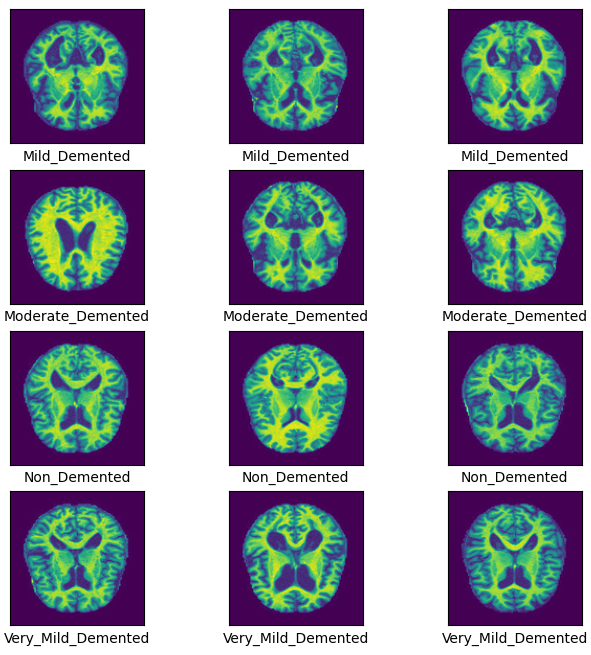

In [10]:
sample_images = []

plt.figure(figsize = (8, 8))
for i in range(nb_classes):
  images_to_show = os.listdir(os.path.join(args.train_dir, classes[i]))[:3]
  for j in range(3):
    plt.subplot(nb_classes, 3, (i) * 3 + (j + 1))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    path_to_img = os.path.join(args.train_dir, classes[i], images_to_show[j])
    img = mpimg.imread(path_to_img)
    sample_images.append(path_to_img)
    plt.imshow(img)
    plt.xlabel(classes[i])


plt.show()



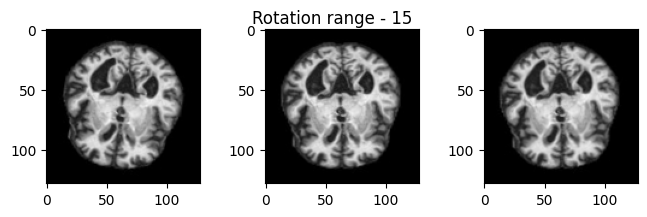

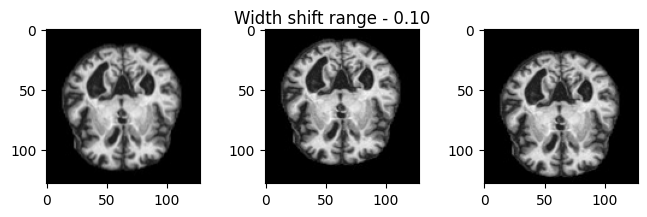

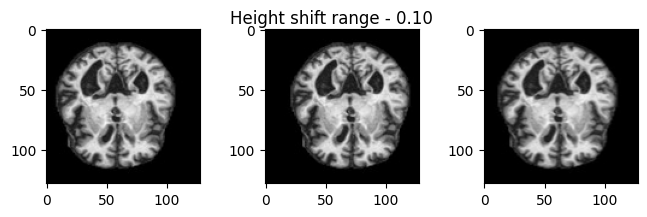

In [11]:
def show_augumented_images():
  img = load_img(sample_images[0], target_size = (128, 128))
  img_tensor = img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis = 0)
  

  def show_image(datagen, title):
    pic = datagen.flow(img_tensor, batch_size = 1)
    plt.figure(figsize = (8, 2))

    for i in range(3):
      plt.subplot(1, 3, i + 1)
      batch = pic.next()
      image_ = batch[0].astype('uint8')
      plt.imshow(image_)
    plt.suptitle(title)
    plt.show()

  datagen = ImageDataGenerator(rotation_range = 15)
  show_image(datagen, "Rotation range - 15")

  datagen = ImageDataGenerator(width_shift_range = 0.10)
  show_image(datagen, "Width shift range - 0.10")

  datagen = ImageDataGenerator(height_shift_range = 0.10)
  show_image(datagen, "Height shift range - 0.10")


show_augumented_images()

### Generators

In [12]:
# add data augmentation to the generator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #ENTER YOUR CODE
    rotation_range = 15,
    width_shift_range = 0.10,
    height_shift_range = 0.10
    #END OF YOUR CODE
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    args.train_dir,
    target_size=(args.im_width, args.im_height),
    batch_size=args.batch_size,
)

validation_generator = test_datagen.flow_from_directory(
    args.valid_dir,
    target_size=(args.im_width, args.im_height),
    batch_size=args.batch_size,
)

test_generator = test_datagen.flow_from_directory(
    args.test_dir,
    target_size=(args.im_width, args.im_height),
    batch_size=args.batch_size
)

Found 4504 images belonging to 4 classes.
Found 1207 images belonging to 4 classes.
Found 689 images belonging to 4 classes.


### Model

In [ ]:
model = Xception(weights='imagenet', include_top=False)
model = add_new_last_layer(model, nb_classes)

model.summary()

## Training

### TODO: Perform training (transfer learning and fine tuning) to get the best results you can.


### Transfer learning

In [14]:
setup_to_transfer_learn(model, args)

In [ ]:


history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 5,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

Epoch 1/5
35/35 [==============================] - 1190s 33s/step - loss: 1.0511 - accuracy: 0.4899 - val_loss: 0.9676 - val_accuracy: 0.5469
Epoch 2/5
35/35 [==============================] - 115s 3s/step - loss: 0.9541 - accuracy: 0.5427 - val_loss: 0.9403 - val_accuracy: 0.5330
Epoch 3/5
35/35 [==============================] - 114s 3s/step - loss: 0.9248 - accuracy: 0.5576 - val_loss: 0.9867 - val_accuracy: 0.5174
Epoch 4/5
35/35 [==============================] - 115s 3s/step - loss: 0.9102 - accuracy: 0.5624 - val_loss: 0.9501 - val_accuracy: 0.5312
Epoch 5/5
35/35 [==============================] - 113s 3s/step - loss: 0.8933 - accuracy: 0.5836 - val_loss: 0.9485 - val_accuracy: 0.5382


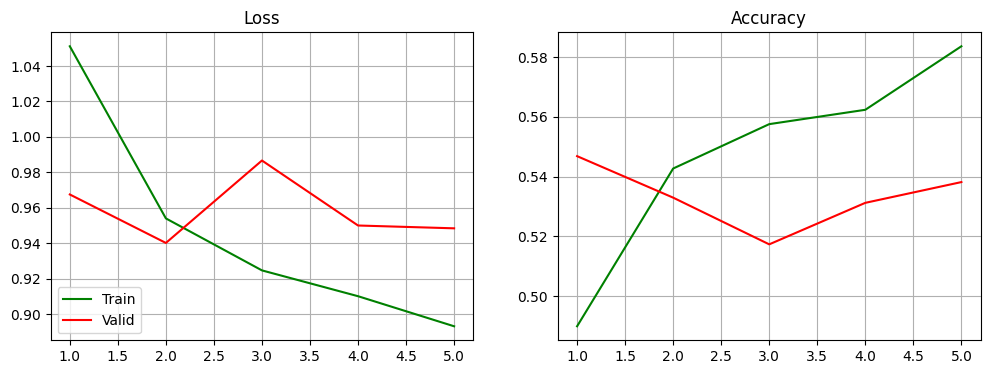

In [ ]:
tl_history = process_and_display(history)
model.save_weights('/content/drive/My Drive/checkpoints/transfer_learning')

In [15]:
model.load_weights('/content/drive/My Drive/checkpoints/transfer_learning')

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 15,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

Epoch 1/15
35/35 [==============================] - 1084s 30s/step - loss: 0.8854 - accuracy: 0.5898 - val_loss: 0.9439 - val_accuracy: 0.5330
Epoch 2/15
35/35 [==============================] - 129s 4s/step - loss: 0.8749 - accuracy: 0.5898 - val_loss: 0.9379 - val_accuracy: 0.5339
Epoch 3/15
35/35 [==============================] - 129s 4s/step - loss: 0.8728 - accuracy: 0.5916 - val_loss: 0.9235 - val_accuracy: 0.5521
Epoch 4/15
35/35 [==============================] - 120s 3s/step - loss: 0.8598 - accuracy: 0.5951 - val_loss: 0.9718 - val_accuracy: 0.5087
Epoch 5/15
35/35 [==============================] - 131s 4s/step - loss: 0.8547 - accuracy: 0.5992 - val_loss: 0.9606 - val_accuracy: 0.5312
Epoch 6/15
35/35 [==============================] - 129s 4s/step - loss: 0.8474 - accuracy: 0.6184 - val_loss: 0.9346 - val_accuracy: 0.5590
Epoch 7/15
35/35 [==============================] - 116s 3s/step - loss: 0.8378 - accuracy: 0.6175 - val_loss: 0.9172 - val_accuracy: 0.5547
Epoch 8/15


In [ ]:
model.save_weights('/content/drive/My Drive/checkpoints/2/transfer_learning')

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 15,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

In [ ]:
model.save_weights('/content/drive/My Drive/checkpoints/3/transfer_learning')

### Fine tuning

In [17]:
model.layers[126].get_config()['name']

'block14_sepconv1'

In [ ]:
setup_to_finetune(model, args, not_trainable=126)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 2,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

Epoch 1/2
35/35 [==============================] - 121s 3s/step - loss: 0.8285 - accuracy: 0.6181 - val_loss: 0.8897 - val_accuracy: 0.5425
Epoch 2/2
35/35 [==============================] - 115s 3s/step - loss: 0.6388 - accuracy: 0.7237 - val_loss: 0.8088 - val_accuracy: 0.6146


In [ ]:
ft126_history = process_and_display(history, tl_history)
model.save_weights('checkpoints/fine_tuning_126')

**You should continue unfreezeng the layers and training the model until the model overfits. Feel free to add as many code cells as you wish**.

# Save the final model

In [ ]:
model.load_weights('checkpoints/fine_tuning_126')
model.save('checkpoints/final')

# TEST SCORES

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('checkpoints/final')

In [18]:
nb_test_samples = get_nb_files(args.test_dir)
test_steps = int (nb_test_samples / args.batch_size)
model.evaluate(test_generator, steps=test_steps)

KeyboardInterrupt: ignored

# TO DO
Show examples how your model works with real images. 
Try to display:
- An image
- Real class of an image
- Estimated class of an image
- Probabilities

Mild_Demented
1/1 [==============================] - 0s 50ms/step
[0.004 0.    0.147 0.849]


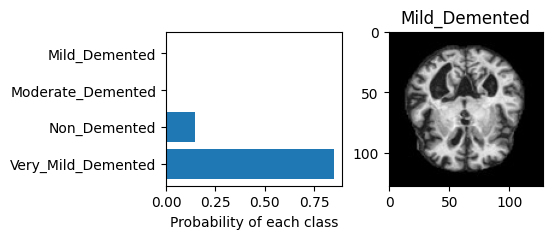

Mild_Demented
1/1 [==============================] - 0s 60ms/step
[0.057 0.    0.139 0.804]


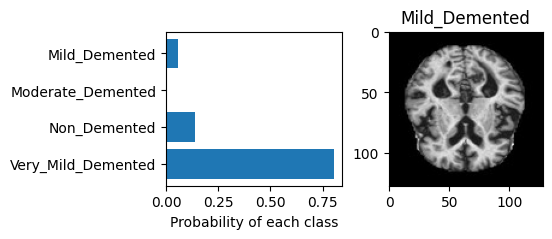

Mild_Demented
1/1 [==============================] - 0s 48ms/step
[0.246 0.001 0.243 0.51 ]


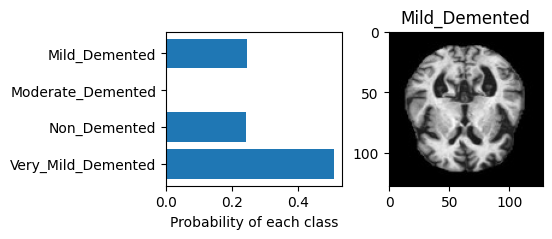

In [50]:
def draw_probability_chart(probs, labels):
  plt.rcdefaults()

  ax = plt.subplot(1, 2, 1)
  ax.barh(labels, probs)
  ax.invert_yaxis()
  ax.set_xlabel('Probability of each class')


def get_image(path, datagen = test_datagen, target_size = (128, 128)):
  img = load_img(path, target_size = target_size)
  img_tensor = img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis = 0)
  transformed_tensor = test_datagen.flow(img_tensor)
  return img, transformed_tensor

def show_image(image, label):
  plt.subplot(1, 2, 2)
  plt.title(label)
  plt.imshow(image)


def show_summary_predict(image_tuple, chart_labels = classes, image_label = ""):
  print(image_tuple[1])
  probs = model.predict(image_tuple[1])[0]
  rounded_probs = np.round_(probs, 3)
  print(rounded_probs)
  plt.figure(figsize = (5, 2))
  draw_probability_chart(rounded_probs, chart_labels)
  show_image(image_tuple[0], image_label)
  plt.show()

def show_summary(probs, image, chart_labels = classes, image_label = ""):
  rounded_probs = np.round_(probs, 3)
  print(rounded_probs)
  plt.figure(figsize = (5, 2))
  draw_probability_chart(rounded_probs, chart_labels)
  show_image(image, image_label)
  plt.show()


#show_summary_predict(get_image(sample_images[0]))

for i in sample_images[:3]:
  real_class = i.split('/')
  print(real_class[-2])

  #img2 = get_image(i)
  #probs = model.predict(img2[1])
  #show_summary(probs[0], img2[0], image_label = real_class[-2])

  show_summary_predict(get_image(i), image_label = real_class[-2])





## Checking wrongly classified images

In [ ]:


wrong_classified_images = []
for i in range(nb_classes):
  img_class = classes[i]
  images = os.listdir(os.path.join(args.valid_dir,img_class))[:20]
  images = [os.path.join(args.valid_dir, classes[i], j) for j in images]

  image_tensors = [get_image(j) for j in images]

  for j in range(len(image_tensors)):
      tensor = image_tensors[j]
      probs = model.predict(tensor[1])
      print(np.round(probs))
      is_correctly_classified = np.round(probs)[0][i] == 1
      print(is_correctly_classified)
      if not is_correctly_classified:
        wrong_classified_images.append(
            (images[j], tensor[0], probs[0], img_class)
        )


print(wrong_classified_images)
  #image_tensors = np.array(image_tensors, dtype=np.uint8)

  #predictions = model.predict(image_tensors)
  #wrong_predictions = images[predictions[i] != 1]
  #desired_images[img_class: wrong_predictions]



In [59]:
from collections import defaultdict
number_of_wrongly_classified_in_each_class = defaultdict(lambda: 0)
for i in wrong_classified_images:
  number_of_wrongly_classified_in_each_class[i[3]] += 1

number_of_wrongly_classified_in_each_class

defaultdict(<function __main__.<lambda>()>,
            {'Mild_Demented': 20,
             'Moderate_Demented': 10,
             'Non_Demented': 6,
             'Very_Mild_Demented': 10})

In [76]:
wrongly_classified_probs = [i[2] for i in wrong_classified_images]
wrongly_classified_correct_class = [i[3] for i in wrong_classified_images]
wrongly_classified_file_name = [i[0].split('/')[-1] for i in wrong_classified_images]

import pandas as pd
df = pd.DataFrame(np.round(wrongly_classified_probs, 5), columns = classes)
df['Correct_class'] = wrongly_classified_correct_class
df['Filename'] = wrongly_classified_file_name
df

,Mild_Demented,Moderate_Demented,Non_Demented,Very_Mild_Demented,Correct_class,Filename
0,0.01552,0.00001,0.01102,0.97344,Mild_Demented,mild_666.jpg
1,0.00882,0.00002,0.23835,0.75282,Mild_Demented,mild_668.jpg
2,0.01665,0.00001,0.00897,0.97437,Mild_Demented,mild_665.jpg
3,0.00587,0.00003,0.67788,0.31622,Mild_Demented,mild_667.jpg
4,0.00073,0.00001,0.70610,0.29315,Mild_Demented,mild_682.jpg
5,0.03556,0.00005,0.02866,0.93573,Mild_Demented,mild_684.jpg
6,0.00375,0.00001,0.36459,0.63165,Mild_Demented,mild_705.jpg
7,0.00895,0.00003,0.09071,0.90031,Mild_Demented,mild_671.jpg
8,0.00167,0.00000,0.41913,0.57920,Mild_Demented,mild_706.jpg
9,0.01747,0.00001,0.06895,0.91357,Mild_Demented,mild_688.jpg


In [52]:
for i in wrong_classified_images:
  show_summary(i[2], i[1], image_label = i[3])

Output hidden; open in https://colab.research.google.com to view.